# 3. 파이토치로 구현하는 ANN

내가 EMNIST 분류 문제에서 CNN 모델 생성을 위해, tensorflow나 pytorch 라이브러리를 사용하지 않음을 여차 말하고 있는 중이다. 해당 절을 읽으면서, baseline code를 보고 모델을 생성하며 작성한 code에서 각 부분들이 왜 선언되고 사용되는지 이해할 수 있게 되었다. 내가 EMNIST 분류 문제에서 사용했던 코드를 함께 사용하여 이번 절을 정리하려고 한다.

DACON EMNIST 분류 문제: <a href="https://github.com/JerryKwon/EMNST_DACON">git repo</a>

## 3.1. 텐서와 Autograd

텐서는 파이토치에서 다양한 수식을 계산하는데 사용하는 가장 기본적인 자료구조.

* 차원 or 랭크
    * 1 -> 스칼라, shape: []
    * [1,2,3] -> 벡터, shape: [3]
    * [[1,2,3]] -> 행렬, shape [1,3]
    * [[[1,2,3]]] -> n 랭크 텐서, shape [1,1,3]
    
### 3.1.1. unsqueeze, squeeze, view

모두 텐서의 형태를 바꾸는 메소드.

#### unsqueeze()

기존의 텐서에서 임의의 위치에 하나으 차원을 추가하는 메소드

In [2]:
import torch

tensor = torch.tensor([[1,2,3],[1,2,3],[1,2,3]],dtype=torch.float)
print(tensor.shape)
print(tensor.ndimension())

torch.Size([3, 3])
2


In [3]:
unsq = torch.unsqueeze(tensor,0)
print(unsq)
print(unsq.shape)
print(unsq.ndimension())

tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]])
torch.Size([1, 3, 3])
3


#### squeeze()

기존의 텐서에서 랭크의 크기가 1인 랭크를 삭제하여 랭크를 낮추는 메서드

In [4]:
sq = torch.squeeze(unsq)
print(sq)
print(sq.shape)
print(sq.ndimension())

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])
torch.Size([3, 3])
2


#### view()

기존의 텐서를 임의의 형태로 변형하는 메서드

In [5]:
view_t = tensor.view(9)
print(view_t)
print(view_t.shape)
print(view_t.ndimension())

tensor([1., 2., 3., 1., 2., 3., 1., 2., 3.])
torch.Size([9])
1


그러나 임의의 텐서 개수로 특정 shape의 형태로 변경할 수 없는 경우 Exception이 발생한다.

        view_t.view(2,4)
        
왜냐하면 9개의 원소를 가진 텐서를 2,4 형태로 변경하게 되면 1개의 텐서는 나타낼 수 없기 때문이다.

In [6]:
view_t.view(2,4)

RuntimeError: shape '[2, 4]' is invalid for input of size 9

In [7]:
view_t.view(2,5)

RuntimeError: shape '[2, 5]' is invalid for input of size 9

### 3.1.2. pytorch의 행렬곱과 행렬합

pytorch에서 행렬 곱과 합에서 합의 경우에는 일반 수식과 동일한 '+' 기호를 사용하나, 행렬곱의 경우에는 **torch.mm(Matrix Multiplication[??])**을 사용한다.

### 3.1.3. Autograd

딥러닝 알고리즘에서 어떻게 최적값을 찾아서 학습을 진행할 수 있을까?

ML 알고리즘에서 실제값과 예측값의 차이를 최소화함으로써 학습의 정도를 판단할 수 있다. 그리고 그 차이를 가지고 가중치를 조절하여 다시 학습을 진행한다. 이는 최적의 point에 도달할 때까지 진행하게 되면 우리가 원하는 ML/DL을 위한 학습이 완료되는 것이다.

우리는 실제값과 예측값의 차이를 거리(distance)라고 한다. 그리고 각 data point들에서 얻어진 거리들을 평균하여 나타낸 것을 오차(loss)라고 한다. 따라서, 오차를 최소화하는 모델을 학습을 통해 만드는 것이 목표이다.

오차를 최소화하는데 사용되는 알고리즘은 아래의 방법들이 있다.

* Gradient Descent (경사하강법)
* Newton's Method
* 기타 등등..

이 중에서 우리는 경사 하강법을 통해서 오차를 최소화하는 방법을 언급한다.

경사하강법과 Newton's Method에 대해서는 대학원 준비과정에서 준비한 QnA 항목에 준비되어 있다. 곧 깃허브를 통해 준비했던 질문들에 대한 답변을 자세하게 정리할 예정임으로 해당 포스트가 올라오면 이를 참고해주길 바란다.

경사하강법에 대해서 간단히 말하지면, '임의의 손실함수에 대해서 기울기 경사를 따라서 손실함수의 최적점에 도착하자!' 라는 아이디어이다. 그러나 손실함수의 최적점을 찾았을 때, 정말 그점이 최적점인가? 등의 "부분 최적화"로 인해 학습이 올바르게 이뤄지지 않는 경우도 있다. 이 때문에 딥러닝의 역사에서 암흑기가 찾아왔다. 이는 Newon's Method와 동일하게 별도의 QnA 포스트에서 역사에 대해서 언급할 예정이다.

**경사하강법에 대해서 알고 싶다면?**

<a href="https://www.youtube.com/watch?v=GmtqOlPYB84">[딥러닝] 2. 선형회귀와 Gradient Descent</a> (Author's Recommendation)

Autograd는 미분계산을 자동화 하여 경사하강법을 구현하는 수고를 덜어준다. 파이토치의 기능으로 인해 w에 대한 미분값은 w.grad에 저장된다.

In [8]:
w = torch.tensor(1.0,requires_grad=True)
a = w*3
l = a**2

In [9]:
l.backward()
print('l을 w로 미분한 값은 {}'.format(w.grad))

l을 w로 미분한 값은 18.0


In [10]:
w.grad

tensor(18.)

## 3.2. 경사하강법으로 이미지 복원하기

실습을 위해 임의의 이미지를 weird_function()이라는 메서드를 만들어 노이징을 주고, 올바른 이미지로 처리할 수 있도록 하는 이미지 복원을 수행해보자.

* image_link: <a href="https://github.com/keon/3-min-pytorch/blob/master/03-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EB%8A%94_ANN/broken_image_t.p">git repo</a> 

이미지 복원을 위한 사고과정
1. 오염된 이미지와 크기와 같은 랜덤 텐서 생성
2. 랜덤 텐서를 function()에 입력하여 똑같이 오염된 이미지를 가설로 생성
    2.1. 원본 이미지가 함수에 입력되어 오염된 이미지를 출력함.
    2.2. 인위적으로 생성한 무작위 이미지가 함수에 입력되어 가설을 출력한다.
3. 가설과 오염된 이미지가 같다면, 무작위 이미자와 원본 이미지도 같을 것이다.
4. 그러므로 function(random_tensor) = broken_image 관계가 성립되도록 만든다.

In [11]:
import torch
import pickle
import matplotlib.pyplot as plt

In [14]:
with open("./broken_image_t.p","rb") as file:
    bk_img = pickle.load(file)
    
print(bk_img)
print(bk_img.shape)

[-0.00946443 -0.00041859  0.00943783 ... -0.00143515 -0.00010314
 -0.00358077]
(10000,)


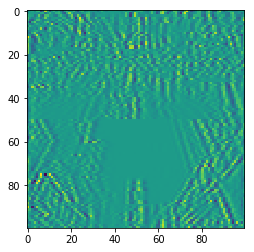

In [15]:
plt.imshow(bk_img.reshape(100,100))

In [49]:
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [50]:
random_tensor = torch.randn(10000,dtype=torch.float)

In [51]:
random_tensor

tensor([ 0.6056,  1.3391,  1.2501,  ..., -0.4398, -0.6257,  1.2832])

In [52]:
wrd_img = weird_function(random_tensor)

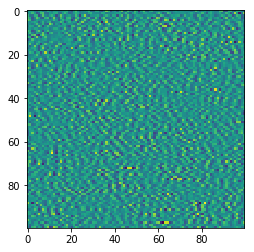

In [53]:
plt.imshow(wrd_img.reshape(100,100))

In [48]:
wrd_img.shape

torch.Size([33750])